In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ipc=pd.read_csv("Data/ethiopia_admin1_fewsnet_population.csv",index_col=0)
adm1c='ADM1_EN' #"ADMIN1" #

In [3]:
# df_ipc=pd.read_csv("Data/ethiopia_admin1_fewsnet_population.csv",index_col=0)
# adm1c="ADMIN1" 

In [4]:
df_ipc.head()

,date,ADM1_EN,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,ML1_2,ML1_3,ML1_4,ML1_5,ML2_1,ML2_2,ML2_3,ML2_4,ML2_5,total_pop
0,2009-07-01,Addis Ababa,3585647,2726821,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2009-07-01,Afar,1904414,1448271,0,702984,745287,0,0,0,702984,745287,0,0,0,862230,586041,0,0,1448271
2,2009-07-01,Amhara,21790172,16571038,9531637,1743855,5295546,0,0,9531637,1743855,5295546,0,0,7609926,8961112,0,0,0,16571038
3,2009-07-01,Benishangul Gumz,1102849,838696,838696,0,0,0,0,838696,0,0,0,0,838696,0,0,0,0,838696
4,2009-07-01,Dire Dawa,508918,387022,0,387022,0,0,0,0,387022,0,0,0,0,387022,0,0,0,387022


In [5]:
def get_trigger(row,status,level,perc):
    #range till 6 cause 5 is max level
    cols=[f"{status}_{l}" for l in range(level,6)]
    if row["total_pop"]==0:
        return 0
    if row[cols].sum() >= row["total_pop"]/(100/perc):
        return 1
    else:
        return 0

In [6]:
def get_trigger_increase(row,level,perc):
    #range till 6 cause 5 is max level
    cols_ml1=[f"ML1_{l}" for l in range(level,6)]
    cols_cs=[f"CS_{l}" for l in range(level,6)]
    if row["total_pop"]==0 or row[cols_ml1].sum() == 0:
        return 0
    if row[cols_ml1].sum() >= row[cols_cs].sum()*(1+(perc/100)):
        return 1
    else:
        return 0

In [7]:
df_ipc['date'] = pd.to_datetime(df_ipc['date'])
df_ipc['year'] = df_ipc['date'].dt.year
df_ipc['month'] = df_ipc['date'].dt.month

In [8]:
df_ipc["trigger_CS_3_20"]=df_ipc.apply(lambda x: get_trigger(x,"CS",3,20),axis=1)
df_ipc["trigger_CS_4_2"]=df_ipc.apply(lambda x: get_trigger(x,"CS",4,2.5),axis=1)
df_ipc["trigger_CS_4_20"]=df_ipc.apply(lambda x: get_trigger(x,"CS",4,20),axis=1)
df_ipc["trigger_ML1_3_5"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",3,5),axis=1)
df_ipc["trigger_ML1_4_2"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",4,2.5),axis=1)
df_ipc["trigger_ML1_3_30"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",3,30),axis=1)
df_ipc["trigger_ML1_3_5i"]=df_ipc.apply(lambda x: get_trigger_increase(x,3,5),axis=1)

In [9]:
for c in ["CS_3","CS_4","ML1_3","ML1_4"]:
    df_ipc[f"perc_{c}"]=df_ipc[c]/df_ipc["adjusted_population"]*100

In [10]:
df_ipc.head()

,date,ADM1_EN,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,...,trigger_CS_4_2,trigger_CS_4_20,trigger_ML1_3_5,trigger_ML1_4_2,trigger_ML1_3_30,trigger_ML1_3_5i,perc_CS_3,perc_CS_4,perc_ML1_3,perc_ML1_4
0,2009-07-01,Addis Ababa,3585647,2726821,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.0,0.000000,0.0
1,2009-07-01,Afar,1904414,1448271,0,702984,745287,0,0,0,...,0,0,1,0,1,0,51.460466,0.0,51.460466,0.0
2,2009-07-01,Amhara,21790172,16571038,9531637,1743855,5295546,0,0,9531637,...,0,0,1,0,1,0,31.956634,0.0,31.956634,0.0
3,2009-07-01,Benishangul Gumz,1102849,838696,838696,0,0,0,0,838696,...,0,0,0,0,0,0,0.000000,0.0,0.000000,0.0
4,2009-07-01,Dire Dawa,508918,387022,0,387022,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.0,0.000000,0.0


In [11]:
dict_an={}

In [20]:
#Analysis 1: 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation)
df_an1 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1)]
dict_an["an1"]={"df":df_an1,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + 2.5% IPC4+ (current situation)"}
dict_an["an1"]["df_group"]=df_an1.groupby(['date','year'], as_index=False)[adm1c].agg(lambda x: list(x))
display(df_an1.groupby(['year', 'month'], as_index=False)[adm1c].agg(lambda x: list(x)))

,year,month,ADM1_EN
0,2009,7,[Somali]
1,2010,1,"[Afar, Gambela, Somali]"
2,2011,4,[Somali]
3,2011,7,"[Oromia, Somali]"
4,2015,10,[Afar]
5,2016,2,"[Afar, Oromia]"
6,2017,6,[Somali]
7,2017,10,[Somali]


In [21]:
# #Analysis 1b: 20% IPC3+ (current situation) + (2.5% IPC4+ (current situation) OR 5% increase in IPC3+ (ML1))
# df_snCS20ML12oML1i = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&((df_ipc['trigger_ML1_4_2']==1)| (df_ipc['trigger_ML1_3_5i'] == 1))]
# df_snCS20ML12oML1i.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x))

In [14]:
# #Analysis 1c: 20% IPC3+ (current situation) + 5% increase in IPC3+ (ML1)
# df_snCS20ML1i = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_3_5i'] == 1)]
# df_snCS20ML1i.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x))

In [15]:
#Analysis 2: 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation) + 5% increase in IPC3+ (ML1)
df_an2 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1) & (df_ipc['trigger_ML1_3_5i'] == 1)]
dict_an["an2"]={"df":df_an1,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + 2.5% IPC4+ (current situation) + 5% increase in IPC3+ (ML1)"}
df_an2.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x))

,year,month,ADM1_EN
0,2010,1,"[Afar, Somali]"
1,2016,2,[Oromia]
2,2017,10,[Somali]


In [16]:
#Analysis 3: IPC4+ at 20% (current situation)
df_snCS420 = df_ipc.loc[df_ipc['trigger_CS_4_20']==1]
display(df_snCS420.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x)))
dict_an["an3"]={"df":df_snCS420,"trig_cols":["CS_4"],"desc":"IPC4+ at 20% (current situation)"}

,year,month,ADM1_EN
0,2009,7,[Somali]
1,2009,10,[Somali]
2,2011,4,[Somali]
3,2011,7,[Somali]
4,2011,10,[Somali]
5,2017,6,[Somali]
6,2017,10,[Somali]


In [24]:
def col_totpop(row,col,df_all):
    pop_col=df_all[df_all.date==row.date][col].sum()
    return pop_col

def col_regpop(row,col,df_an):
    pop_col=df_an[df_an.date==row.date][col].sum()
    return pop_col

In [25]:
df_grouped=dict_an["an1"]["df_group"]
for i in dict_an["an1"]["trig_cols"]:
    df_grouped[f"{i}_tot"]=df_grouped.apply(lambda x: col_totpop(x,i,df_ipc),axis=1)
    df_grouped[f"{i}_reg"]=df_grouped.apply(lambda x: col_regpop(x,i,dict_an["an1"]["df"]),axis=1)

In [26]:
df_grouped

,date,year,ADM1_EN,CS_3_tot,CS_3_reg,CS_4_tot,CS_4_reg,ML1_4_tot,ML1_4_reg
0,2009-07-01,2009,[Somali],36922535,2664781,2062686,2062686,2944859,2944859
1,2010-01-01,2010,"[Afar, Gambela, Somali]",10010974,4788937,0,0,3030038,2037900
2,2011-04-01,2011,[Somali],18554245,2818163,2181414,2181414,2181414,2181414
3,2011-07-01,2011,"[Oromia, Somali]",29556568,15455150,3990219,3990219,3990219,3990219
4,2015-10-01,2015,[Afar],25886751,1460237,832721,253132,832721,253132
5,2016-02-01,2016,"[Afar, Oromia]",16297860,6217765,6687060,6091561,7164463,6091561
6,2017-06-01,2017,[Somali],9394512,1989677,2120446,2120446,2120446,2120446
7,2017-10-01,2017,[Somali],1442489,1442489,1498797,1498797,1498797,1498797


In [27]:
col_add=["perc_CS_4"]+dict_an["an3"]["trig_cols"]
an3_group=dict_an["an3"]["df"].groupby(["date","year"],as_index=False)["ADM1_EN"].agg(lambda x:list(x))
for i in col_add:
    an3_group[f"{i}_reg"]=an3_group.apply(lambda x: col_regpop(x,i,dict_an["an3"]["df"]),axis=1)
    an3_group[f"{i}_tot"]=an3_group.apply(lambda x: col_totpop(x,i,df_ipc),axis=1)
    dict_an["an3"]["df_group"]=an3_group

In [28]:
dict_an["an3"]["df_group"]=dict_an["an3"]["df_group"].rename(columns={"ADM1_EN":"threshold regions","CS_4_reg":"pop. IPC4+ threshold regions","CS_4_tot":"pop. IPC4+ Ethiopia","perc_CS_4_reg":"perc. IPC4+ threshold regions","perc_CS_4_tot":"perc. IPC4+ Ethiopia"})

In [29]:
dict_an["an3"]["df_group"]=dict_an["an3"]["df_group"].round(2)

In [30]:
print("Threshold:",dict_an["an3"]["desc"])
display(dict_an["an3"]["df_group"])

Threshold: IPC4+ at 20% (current situation)


,date,year,threshold regions,perc. IPC4+ threshold regions,perc. IPC4+ Ethiopia,pop. IPC4+ threshold regions,pop. IPC4+ Ethiopia
0,2009-07-01,2009,[Somali],43.63,43.63,2062686,2062686
1,2009-10-01,2009,[Somali],62.29,62.29,2944859,2944859
2,2011-04-01,2011,[Somali],43.63,43.63,2181414,2181414
3,2011-07-01,2011,[Somali],40.67,47.10,2033474,3990219
4,2011-10-01,2011,[Somali],40.67,49.58,2033474,4743790
5,2017-06-01,2017,[Somali],35.93,35.93,2120446,2120446
6,2017-10-01,2017,[Somali],25.40,25.40,1498797,1498797


In [31]:
def plot_aff_col(df_d,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"):
    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")

    fig,ax=plt.subplots(1,figsize=(18,6))
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    df_geo[["geometry",col]].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(df_geo)
#                    )
    gdf.boundary.plot(linewidth=0.2,ax=ax)

    ax.axis("off")
#     df_geo['coords'] = df_geo['geometry'].apply(lambda x: x.centroid.coords[:])
#     df_geo['coords'] = [coords[0] for coords in df_geo['coords']]
    
#     for _, row in df_geo.iterrows():
# #         print(row)
#         plt.text(s=f'{row[col]:.2f}', x = row['coords'][0], y = row['coords'][1],
#            horizontalalignment='center', fontdict = { 'size': 8})#'weight': 'bold',

#         plt.text(s='Data: ' + f'{hue:,}', x=row['coords'][0],y = row['coords'][1] - 0.01 ,
#           horizontalalignment='center', fontdict = {'size': 8})

    plt.show()

In [32]:
def plot_aff_collist(df_d,cols,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"):
    colp_num=2
    rows=len(cols) // colp_num
    rows+=len(cols) % colp_num
    position = range(1,len(cols) + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    colors = 6 #len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    for i,c in enumerate(cols):#range(len(cols)):
  # add every single subplot to the figure with a for loop

        ax = fig.add_subplot(rows,colp_num,position[i])
        df_geo.plot(c, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(df_geo)
#                    )
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        plt.title(c)

    plt.show()

In [33]:
def plot_aff_dates(df_d,df_trig,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",title=None):
    
    num_dates=len(df_trig.date.unique())
    colp_num=3
    rows=num_dates // colp_num
    rows+=num_dates % colp_num
    position = range(1, num_dates + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")

    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_trig.date.unique()):
        ax = fig.add_subplot(rows,colp_num,position[i])
        df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
        leg = ax.get_legend()

        for lbl in leg.get_texts():
            label_text = lbl.get_text()
            upper = label_text.split()[2]
            new_text = f'{float(upper):,.2f}'
            lbl.set_text(new_text)

    if title:
        fig.suptitle(title,fontsize=14)
    fig.tight_layout()#show()
    plt.show()

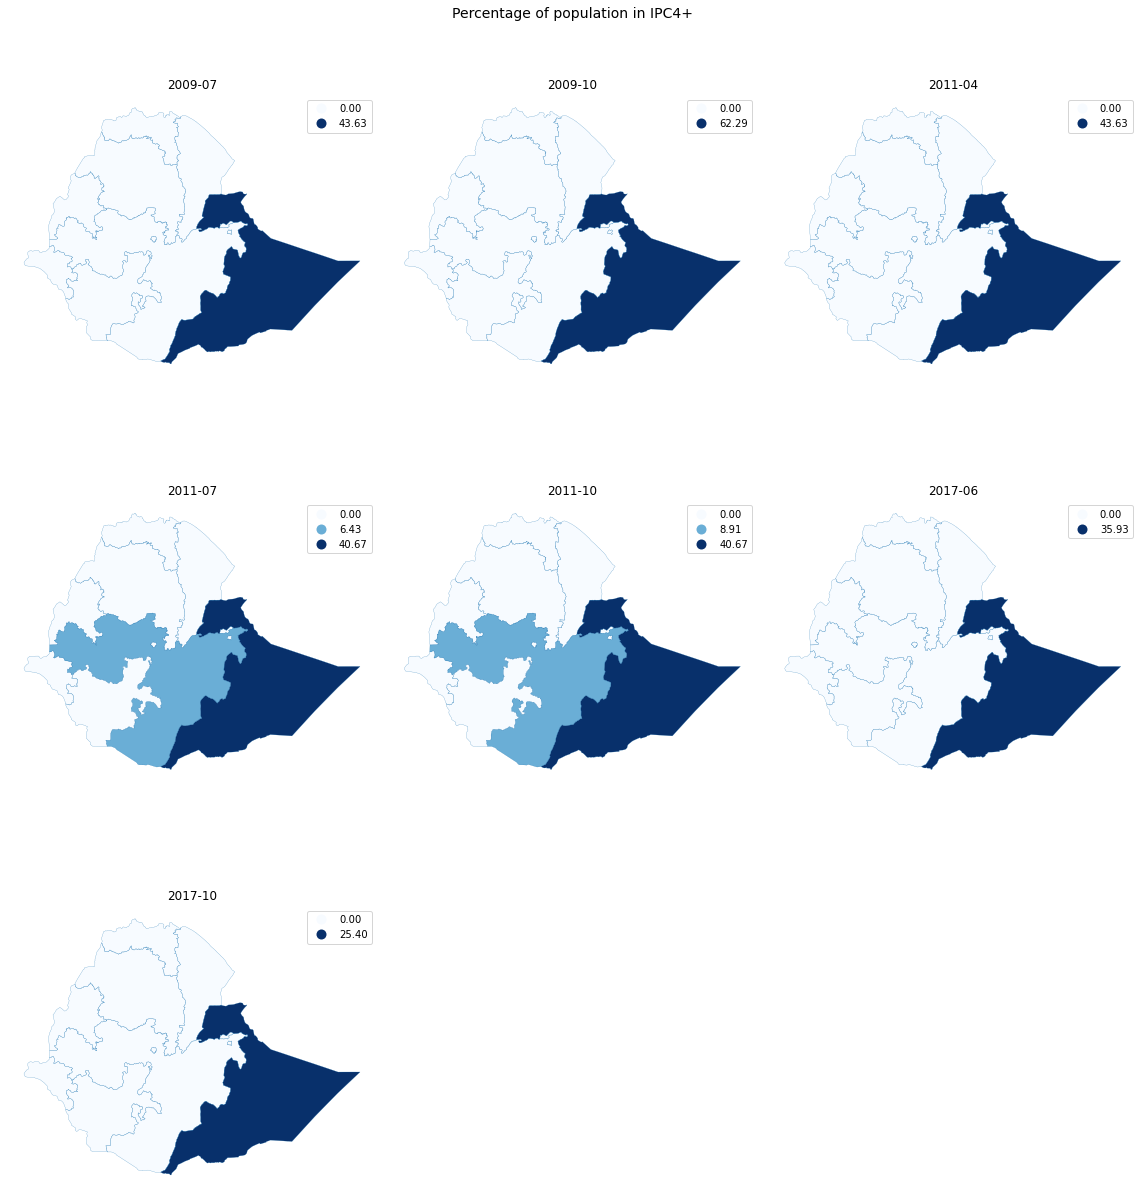

In [35]:
plot_aff_dates(df_ipc,dict_an["an3"]["df"],"perc_CS_4",title="Percentage of population in IPC4+")#dict_an["an3"]["trig_cols"])

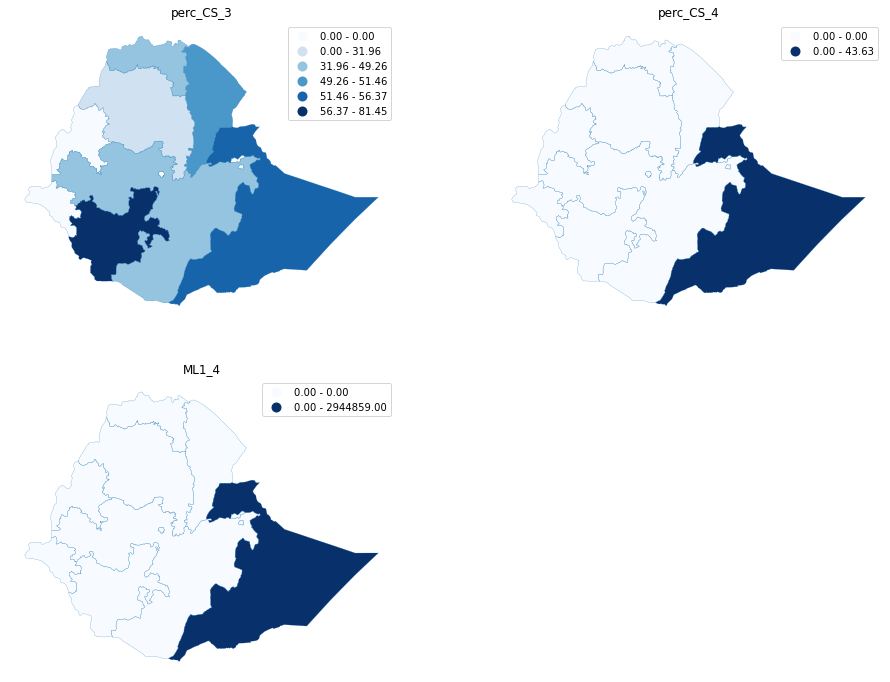

In [36]:
plot_aff_collist(df_ipc[df_ipc.date=="2009-07"],["perc_CS_3","perc_CS_4","ML1_4"])

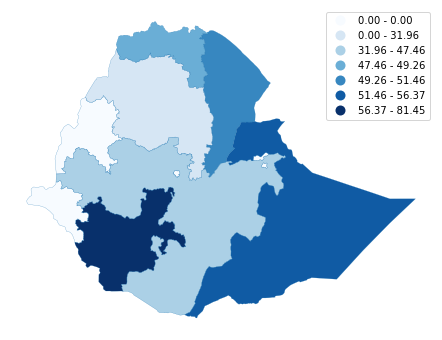

In [37]:
plot_aff_col(df_ipc[df_ipc.date=="2009-07"],"perc_CS_3")

In [27]:
df_ipc["perc_CS4"].value_counts().sort_index()

0.000000     402
2.370135       1
3.917398       1
6.429119       1
8.905067       1
10.363119      1
10.363126      1
14.773934      1
14.773947      1
16.670121      1
25.397149      1
35.931005      1
40.672921      2
43.631949      1
43.631971      1
62.292534      1
Name: perc_CS4, dtype: int64

In [21]:
# sns.distplot(df_ipc["perc_CS4"])#,binwidth=1)#,x="perc_CS4")

In [338]:
def plot_regions_trig(df_trig,adm0c="ADM0_EN",adm1c="ADM1_EN",shape_path="Data/ET_Admin2_OCHA_2019/eth_admbnda_adm2_csa_bofed_20190827.shp"):
     #'ET_Admin2_2014/ET_Admin2_2014.shp'
    gdf = gpd.read_file(shape_path)

    count = 1
    f, ax = plt.subplots(figsize=(12,12))
    for d in ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
        ax2 = plt.subplot(4, 4, count)
        gdf.plot(ax=ax2, color='#DDDDDD', edgecolor='#BBBBBB')
        regions = df_trig[adm1c].loc[df_trig['year'].astype(str)==d]
        gdf.loc[gdf[adm1c].isin(regions)].plot(ax=ax2, color='red')
        plt.title("Regions triggered")
        count+=1
    plt.show()

/Users/tinkavalentijn/opt/anaconda3/envs/aafi/lib/python3.8/site-packages/geopandas/plotting.py:484: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/tinkavalentijn/opt/anaconda3/envs/aafi/lib/python3.8/site-packages/geopandas/plotting.py:484: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/tinkavalentijn/opt/anaconda3/envs/aafi/lib/python3.8/site-packages/geopandas/plotting.py:484: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/tinkavalentijn/opt/anaconda3/envs/aafi/lib/python3.8/site-packages/geopandas/plotting.py:484: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/tinkavalentijn/opt/anaconda3/envs/aafi/lib/python3.8/site-packages/geopandas/plotting.py:484: UserWarning: The GeoDataFrame you are attemptin

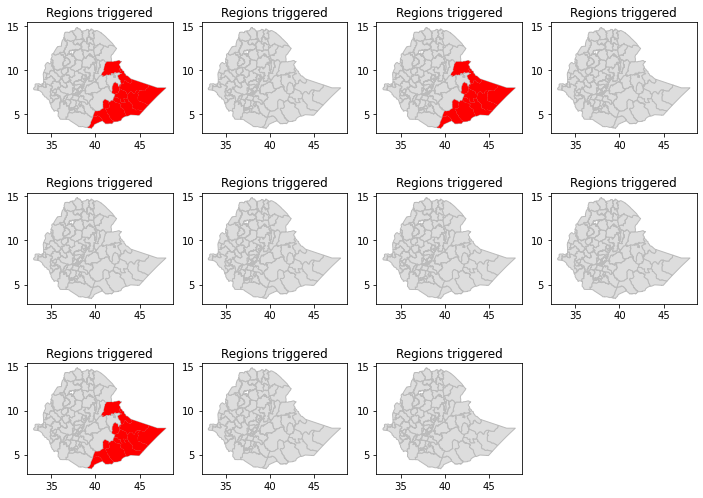

In [339]:
plot_regions_trig(df_snCS420)

In [99]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
fig = make_subplots(
    rows=6, cols=2)#,
    #subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4"))

fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),
              row=1, col=1)

fig.add_trace(go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
              row=1, col=2)

fig.add_trace(go.Scatter(x=[300, 400, 500], y=[600, 700, 800]),
              row=2, col=1)

fig.add_trace(go.Scatter(x=[4000, 5000, 6000], y=[7000, 8000, 9000]),
              row=2, col=2)

fig.update_layout(height=500, width=700,
                  title_text="Multiple Subplots with Titles")

fig.show()

In [134]:
12%7

5

In [138]:
str((7/row)+1)[0]

'8'

In [140]:
idx=12
row = idx%2 + 1
col = int(str((idx/2) + 1)[0])

In [142]:
row

1

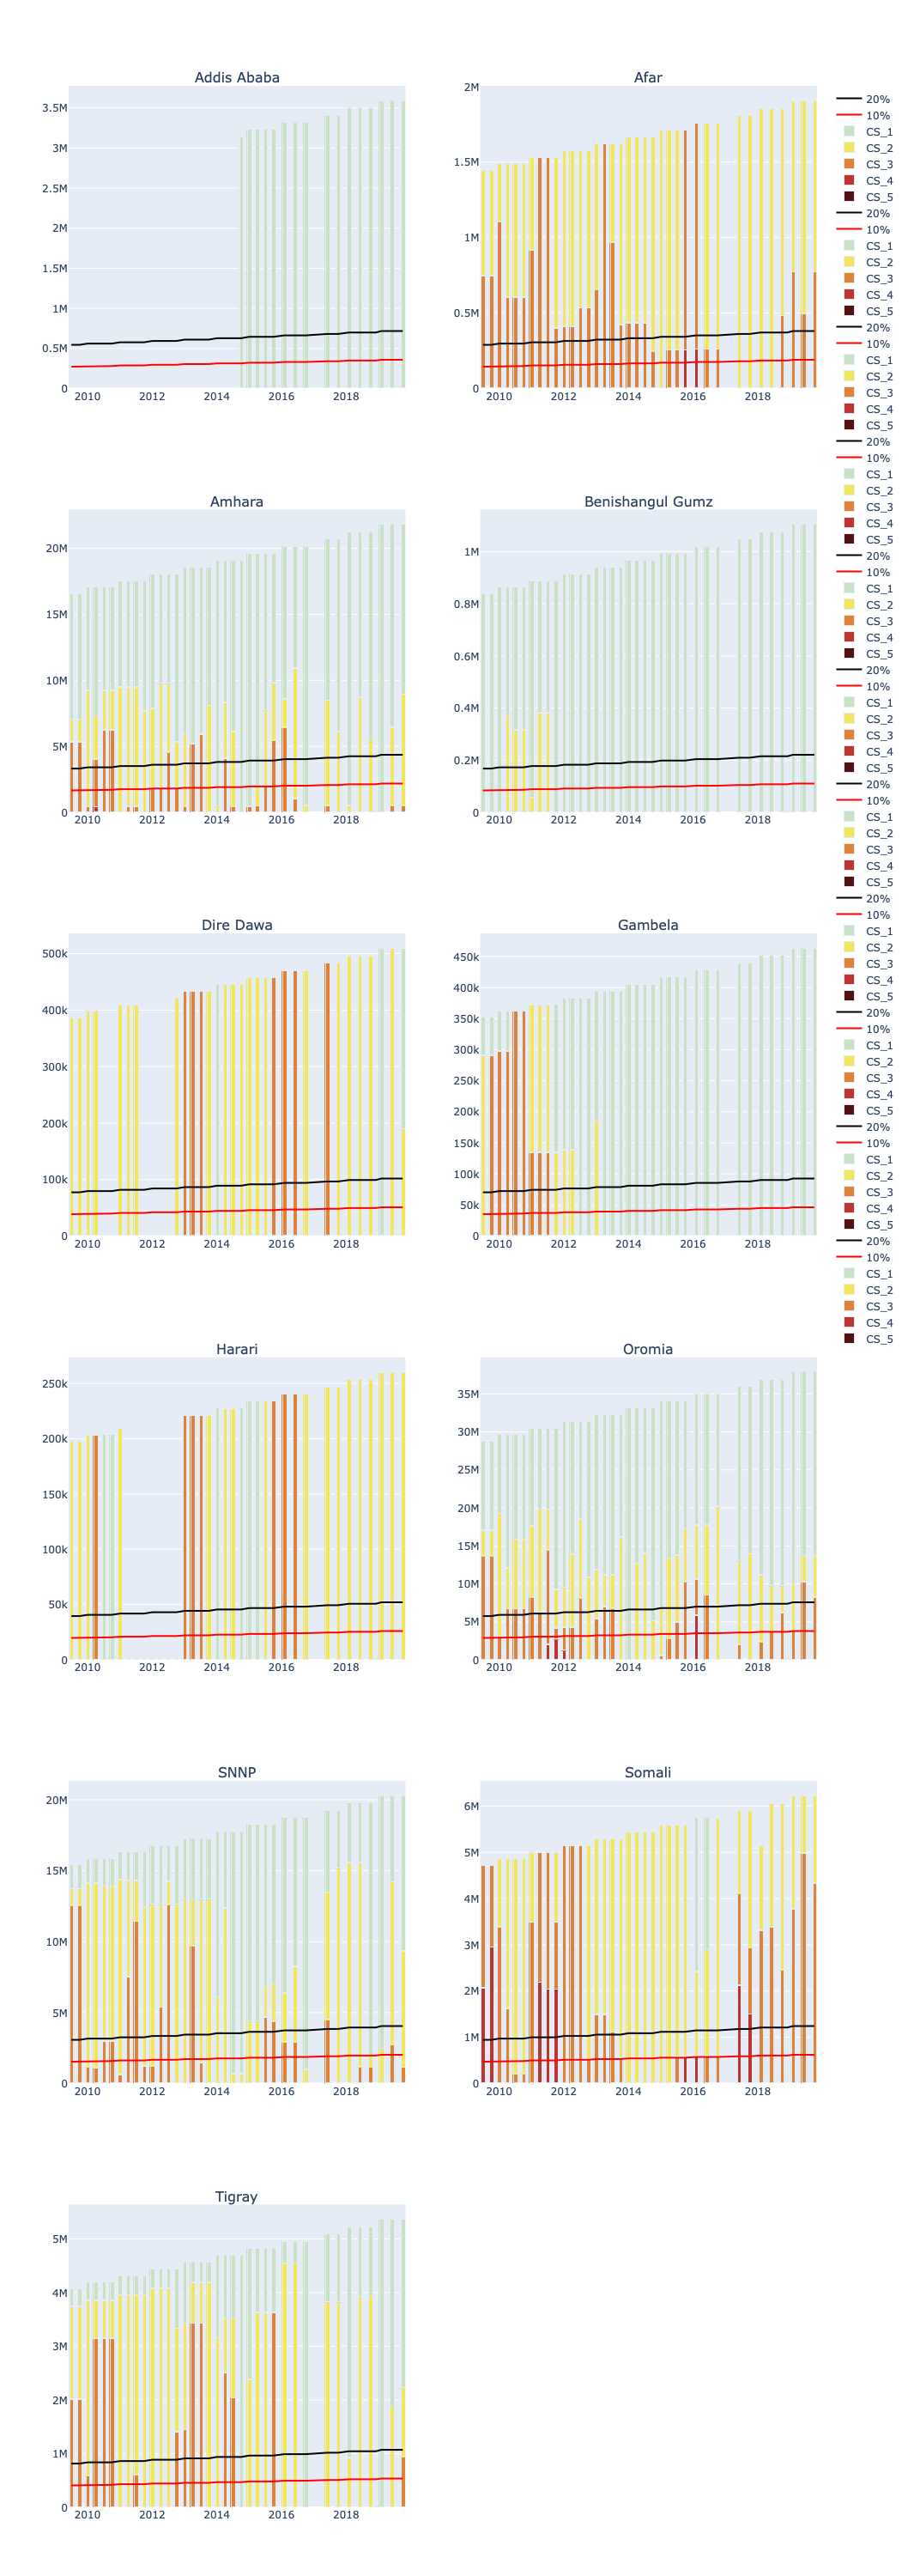

In [149]:
# data=df_ipc[df_ipc.ADM1_EN=="Oromia"]
colp_num=2
num_adm=len(df_ipc.ADM1_EN.unique())
rows=num_adm // colp_num
rows+=num_adm % colp_num
fig = make_subplots(
    rows=rows, cols=colp_num,subplot_titles=list(df_ipc.ADM1_EN.unique()),vertical_spacing=0.05)
for k,a in enumerate(df_ipc.ADM1_EN.unique()):
    col = k%colp_num + 1
    row = int(str((k/colp_num) + 1)[0])
#     print(k)
    data=df_ipc[df_ipc.ADM1_EN==a]
    CS_list=[]
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    for i in range(5,0,-1):
        fig.add_trace(go.Bar(name=f'CS_{i}',x=data["date"],y=data[f"CS_{i}"],marker_color=color_map[i]),row=row,col=col)
    fig.add_trace(go.Scatter(x=data['date'], y=data['adjusted_population']/10,line=dict(
                    color='Red'),name="10%"),row=row,col=col)
    fig.add_trace(go.Scatter(x=data['date'], y=data['adjusted_population']/5,line=dict(
                    color='black'),name="20%"),row=row,col=col)
#     fig.add_trace(data=CS_list,row=k,col=1)
# Change the bar mode
fig.update_layout(barmode='stack',width=1000,height=3000)
fig.show()

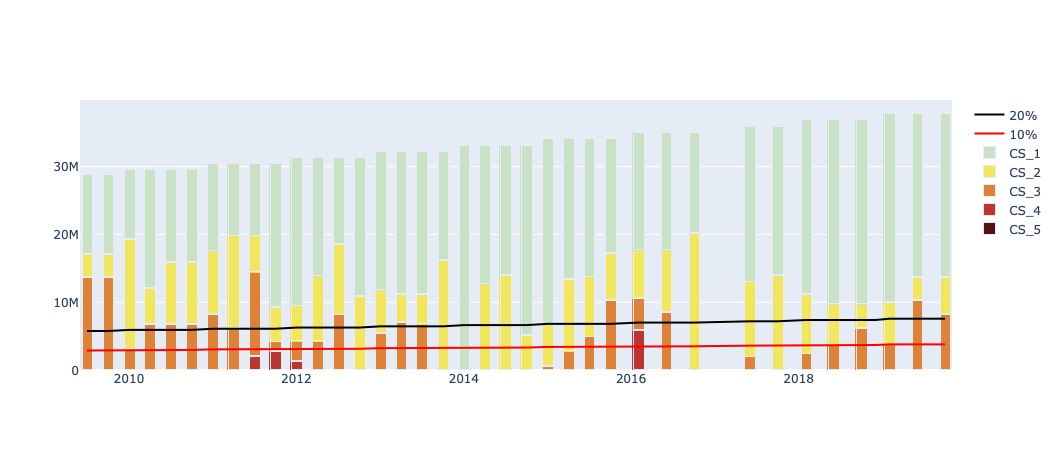

In [36]:
data=df_ipc[df_ipc.ADM1_EN=="Oromia"]
CS_list=[]
color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
for i in range(5,0,-1):
    CS_list.append(go.Bar(name=f'CS_{i}',x=data["date"],y=data[f"CS_{i}"],marker_color=color_map[i]))
CS_list.append(go.Scatter(x=data['date'], y=data['adjusted_population']/10,line=dict(
                color='Red'),name="10%"))
CS_list.append(go.Scatter(x=data['date'], y=data['adjusted_population']/5,line=dict(
                color='black'),name="20%"))
fig = go.Figure(data=CS_list)
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [88]:
def plot_ipclevels(df,adm1c="ADM1_EN"):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    width = 75
    count = 1
    fig, ax = plt.subplots(figsize=(15,30))
    plt.suptitle('Ethiopia Triggers at Admin1 Level')
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        data = df.loc[df[adm1c]==region]
#         total = data['CS_1']+data['CS_2']+data['CS_3']+data['CS_4'].to_numpy()
#         plt.bar(data["date"],data["CS_5"],width=width, color=color_map[5])
#         for i in range(4,0,-1):
#             plt.bar(data["date"],data[f"CS_{i}"],width=width, color=color_map[i],bottom=data[[f"CS_{l}" for l in range(i+1, 6)]].sum().to_numpy())
        p4 = plt.bar(data['date'], data['CS_4'], width=width, color=color_map[4],label="IPC 4")
        p3 = plt.bar(data['date'], data['CS_3'], width=width, color=color_map[3], bottom=data['CS_4'].to_numpy(),label="IPC 3")
        p2 = plt.bar(data['date'], data['CS_2'], width=width, color=color_map[2], bottom=(data['CS_3']+data['CS_4']).to_numpy(),label="IPC 2")
        p1 = plt.bar(data['date'], data['CS_1'], width=width, color=color_map[1], bottom=(data['CS_2']+data['CS_3']+data['CS_4']).to_numpy(),label="IPC 1")
        p5 = plt.plot(data['date'], data['adjusted_population']/10 , color='red',label="10%")
        p6 = plt.plot(data['date'], data['adjusted_population']/5, color='black',label="20%")
        plt.title(region + ' Current Situation')
#         ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('IPC 1', 'IPC 2', 'IPC 3', 'IPC 4', '10 %', '20 %'),loc="upper right")
        ax.legend(loc="upper right")
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1

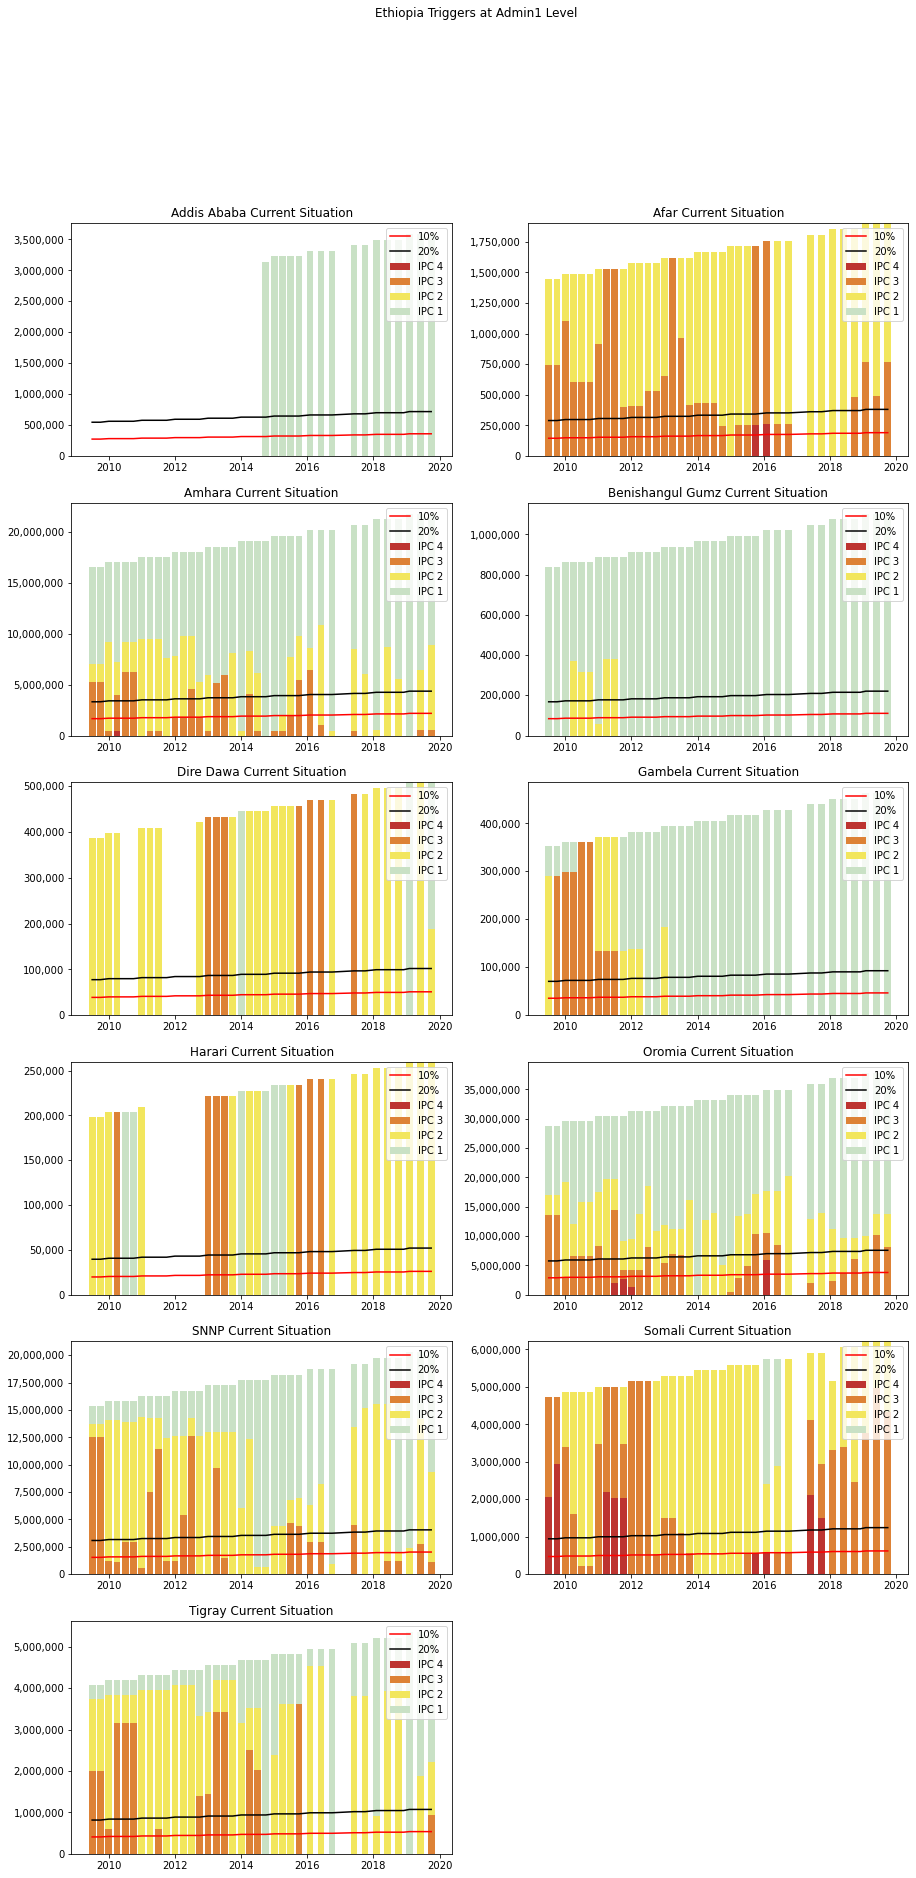

In [89]:
plot_ipclevels(df_ipc)

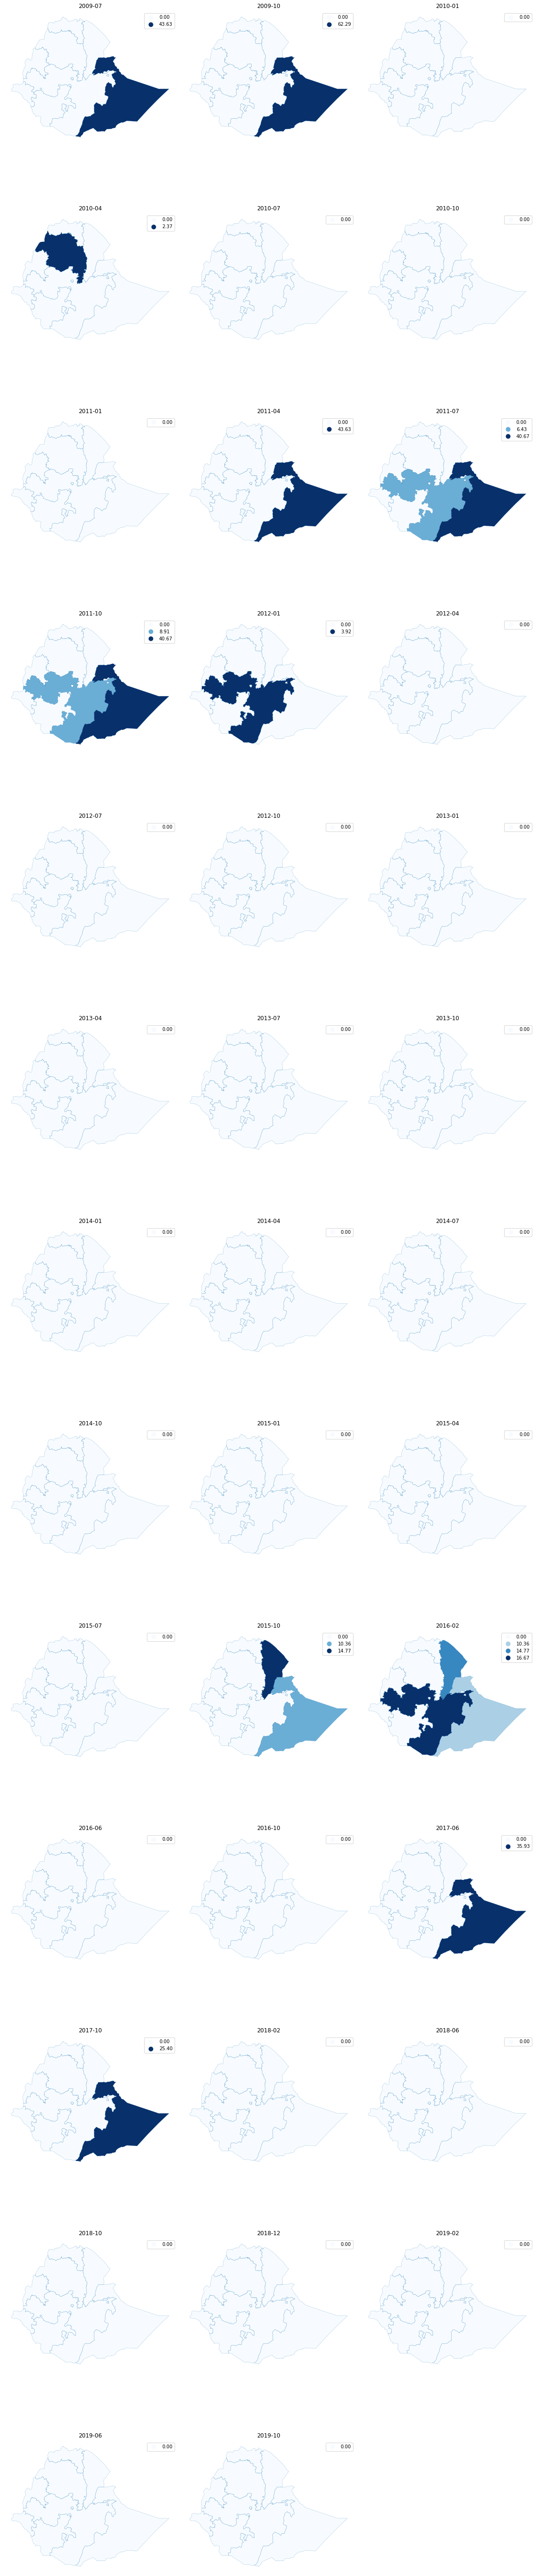

In [232]:
plot_aff_dates(df_ipc,df_ipc,["perc_CS4"])

### Missing data

In [54]:
print("Number of date-admin1 combinations with no IPC CS data:", len(df_ipc[df_ipc.total_pop==0]))

Number of date-admin1 combinations with no IPC CS data: 45


In [57]:
print("Percentage of missing data:",len(df_ipc[df_ipc.total_pop==0])/len(df_ipc)*100)

Percentage of missing data: 10.76555023923445
